# Define the system  

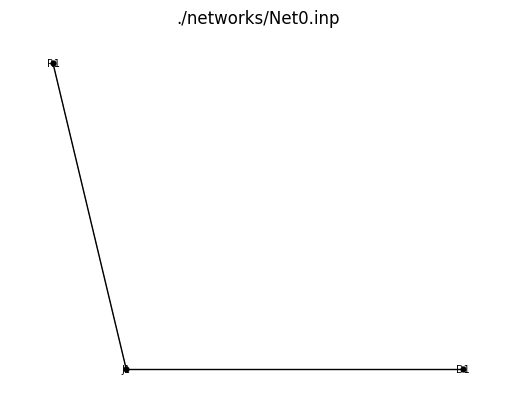

<Axes: title={'center': './networks/Net0.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

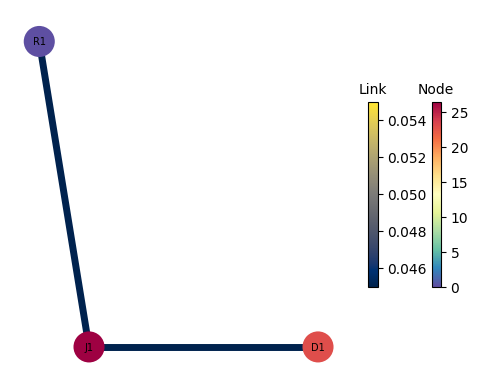

<Axes: >

In [77]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [3]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_pressure

array([26.477, 22.954], dtype=float32)

In [ ]:
plt.cm.

In [4]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([0.05, 0.05], dtype=float32)

In [5]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

## Run with the QUBO Polynomial Solver

In [6]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [90]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (2./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 3
step = (100/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 100.000000 (res: 14.285714)
Flow Encoding : -2.000000 => -0.000000 | 0.000000 => 2.000000 (res: 0.064516)


Solve the system classically

In [91]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, cvgd = net.classical_solutions()
ref_sol / ref_values

array([1.   , 1.   , 0.999, 0.998])

In [92]:
encoded_ref_sol/ ref_values

array([0.987, 0.987, 0.987, 0.948])

In [93]:
P0, P1, P2, P3 = net.matrices

In [94]:
p0 = P0.reshape(
    -1,
) + P1[
    :, :2
].sum(-1)
p0

array([ 0.   ,  1.766, 99.077,  0.652])

In [95]:
net.convert_solution_from_si(ref_sol)

array([ 1.766,  1.766, 86.797, 75.168])

In [96]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model,  num_reads=10000, options={"sampler" : sampler})
sol = net.extract_data_from_model(model)

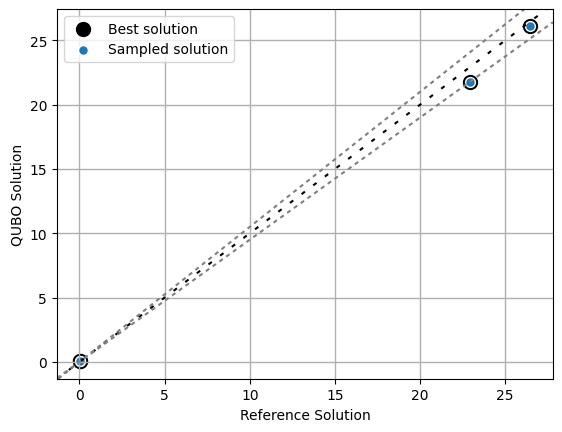

In [99]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values, encoded_ref_sol, c='black', s=100, label='Best solution')
plt.scatter(ref_values, sol, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
plt.legend()
# plt.xlim([0.01,0.1])
# plt.ylim([0.01,0.1])
# plt.loglog()

In [98]:
net.qubo.qubo_dict.num_variables

66

In [17]:
print(model.__str__())

cons:
mass_balance[J1]:   ((expected_demand[J1]-flow[P1])+flow[P2])
mass_balance[D1]:   (expected_demand[D1]-flow[P2])
approx_darcy_wesibach_headloss[P1]:   (((((-(dw_resistance_0[P1]))-(dw_resistance_1[P1]*flow[P1]))-(dw_resistance_2[P1]*(flow[P1]**2.0)))+source_head[R1])-head[J1])
approx_darcy_wesibach_headloss[P2]:   (((((-(dw_resistance_0[P2]))-(dw_resistance_1[P2]*flow[P2]))-(dw_resistance_2[P2]*(flow[P2]**2.0)))+head[J1])-head[D1])

vars:
flow[P1]:   flow[P1]
flow[P2]:   flow[P2]
head[J1]:   head[J1]
head[D1]:   head[D1]



# Embed the problem

In [100]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

In [113]:
net.qubo.qubo_dict.to_qubo()[0]

{('x_004_004', 'x_002_001'): 999996.3546150491,
 ('x_002_001*x_004_004', 'x_002_001'): -2000000.0,
 ('x_002_001*x_004_004', 'x_004_004'): -2000000.0,
 ('x_004_003', 'x_002_001'): 999998.1773075246,
 ('x_004_003', 'x_004_004'): 1000005.6999586402,
 ('x_004_003', 'x_002_001*x_004_004'): 1000000.0,
 ('x_002_001*x_004_003', 'x_002_001'): -2000000.0,
 ('x_002_001*x_004_003', 'x_004_003'): -2000000.0,
 ('x_003_003', 'x_004_004'): -0.26638917793964617,
 ('x_003_003', 'x_002_001*x_004_004'): 0.5327783558792923,
 ('x_003_003', 'x_004_003'): -0.13319458896982309,
 ('x_003_003', 'x_002_001*x_004_003'): 0.26638917793964617,
 ('x_001_001', 'x_003_003'): 999762.5552928579,
 ('x_003_003*x_001_001', 'x_004_004'): 0.5327783558792923,
 ('x_003_003*x_001_001', 'x_002_001*x_004_004'): -1.0655567117585847,
 ('x_003_003*x_001_001', 'x_004_003'): 0.26638917793964617,
 ('x_003_003*x_001_001', 'x_002_001*x_004_003'): -0.5327783558792923,
 ('x_003_003*x_001_001', 'x_003_003'): -2000000.0,
 ('x_003_003*x_001_001

In [125]:
target_graph = dnx.pegasus_graph(6)
embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

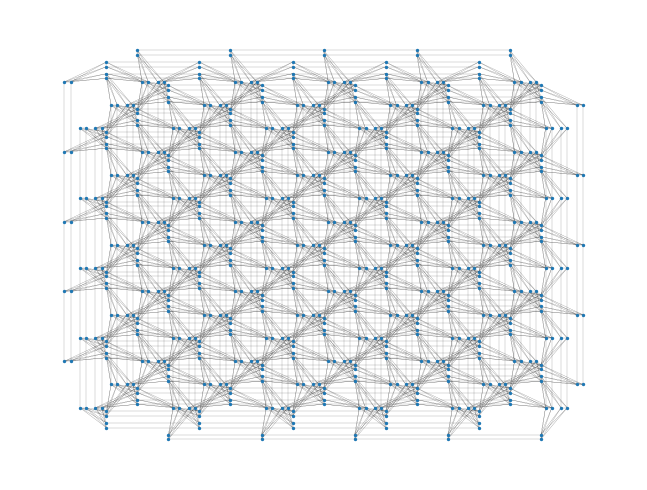

In [124]:
dnx.draw_pegasus(dnx.pegasus_graph(6),  node_size=2, width=0.1)

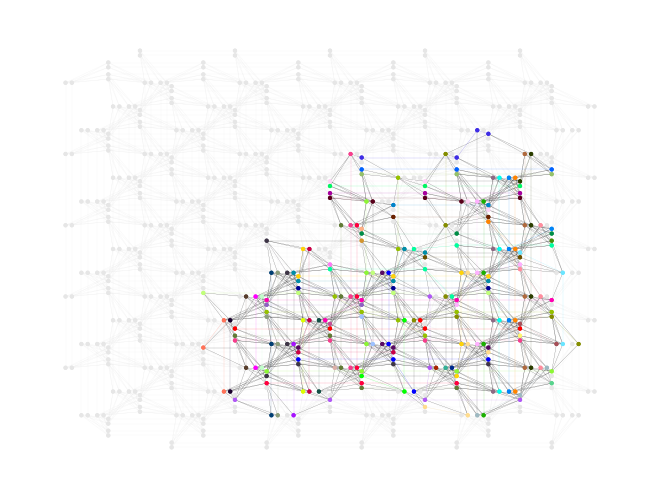

In [127]:
dnx.draw_pegasus_embedding(target_graph, embedding, node_size=4, width=0.1)